In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'extended_fcd_output.csv'  #CSV file path
df = pd.read_csv(file_path)

# Create a scaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'x', 'y', 'speed', 'acceleration' columns
df[['x', 'y', 'speed', 'acceleration']] = scaler.fit_transform(df[['x', 'y', 'speed', 'acceleration']])

# Convert 'angle' from degrees to a range between 0 and 1
df['angle'] = np.radians(df['angle'])  # Convert angle to radians
df['angle'] = scaler.fit_transform(df[['angle']])  # Scale angle

# Assuming 'time' is in seconds and represents the simulation time
df['time'] = scaler.fit_transform(df[['time']])  # Scale time

# Save the normalized DataFrame to a new CSV file
normalized_file_path = 'normalized_extended_fcd_output.csv'  # Update this to your desired output path
df.to_csv(normalized_file_path, index=False)



In [4]:
# Number of timesteps to include in each sequence
timesteps = 5

# Initialize the X and y lists
X, y = [], []

# Loop over each unique vehicle ID to create sequences
for vehicle_id in df['id'].unique():
    vehicle_df = df[df['id'] == vehicle_id]
    for i in range(len(vehicle_df) - timesteps):
        # X will contain the current and past `timesteps` observations including time
        X.append(vehicle_df.iloc[i:i+timesteps][['time', 'x', 'y', 'speed', 'acceleration', 'angle']].values)
        # y will contain the next observation's position
        y.append(vehicle_df.iloc[i + timesteps][['x', 'y']].values)

# Convert the lists to numpy arrays
X = np.array(X)
y = np.array(y)

# Now, split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Convert the data to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(2))  # Predicting 'x' and 'y' coordinates, hence 2 output neurons

In [11]:
model.compile(optimizer='adam', loss='mse')


In [12]:
#train
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)


Epoch 1/100
1260/1260 [==============================] - 6s 3ms/step - loss: 0.0059 - val_loss: 6.4727e-05
Epoch 2/100
1260/1260 [==============================] - 3s 2ms/step - loss: 4.1297e-05 - val_loss: 8.3188e-05
Epoch 3/100
1260/1260 [==============================] - 3s 3ms/step - loss: 2.1953e-05 - val_loss: 2.2451e-05
Epoch 4/100
1260/1260 [==============================] - 5s 4ms/step - loss: 1.7983e-05 - val_loss: 2.2262e-05
Epoch 5/100
1260/1260 [==============================] - 5s 4ms/step - loss: 1.7017e-05 - val_loss: 1.3411e-05
Epoch 6/100
1260/1260 [==============================] - 4s 4ms/step - loss: 1.5235e-05 - val_loss: 1.0396e-05
Epoch 7/100
1260/1260 [==============================] - 4s 4ms/step - loss: 1.3406e-05 - val_loss: 1.6642e-05
Epoch 8/100
1260/1260 [==============================] - 5s 4ms/step - loss: 1.1729e-05 - val_loss: 1.2054e-05
Epoch 9/100
1260/1260 [==============================] - 5s 4ms/step - loss: 1.1651e-05 - val_loss: 5.9586e-06
Epoch

In [14]:
# Convert X_test and y_test to float32 before evaluating the model
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

#test
test_loss = model.evaluate(X_test, y_test)


394/394 [==============================] - 1s 1ms/step - loss: 8.7837e-07


In [16]:
y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE and MAE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


394/394 [==============================] - 1s 3ms/step
Mean Squared Error: 8.783691214375722e-07
Mean Absolute Error: 0.0006050691590644419


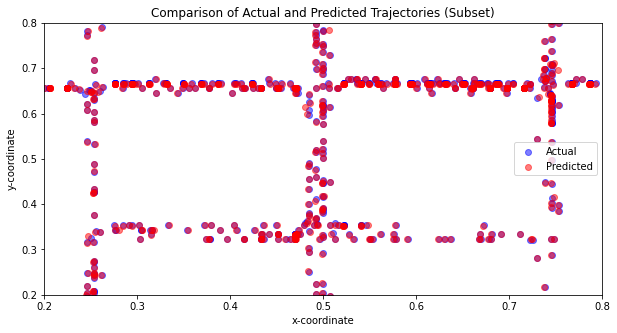

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_test and y_pred are reshaped/flattened appropriately if necessary
plt.figure(figsize=(10, 5))

# Plot a random subset of the data to reduce overplotting
subset_indices = np.random.choice(np.arange(len(y_test)), size=1000, replace=False)
plt.scatter(y_test[subset_indices, 0], y_test[subset_indices, 1], c='b', alpha=0.5, label='Actual')
plt.scatter(y_pred[subset_indices, 0], y_pred[subset_indices, 1], c='r', alpha=0.5, label='Predicted')

# Set a specific range for the x and y axes to zoom in on the area of interest
plt.xlim(0.2, 0.8)  # adjust these limits to zoom in on the area where most data points lie
plt.ylim(0.2, 0.8)  # adjust these limits as well

plt.title('Comparison of Actual and Predicted Trajectories (Subset)')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.legend()
plt.show()